In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import csv
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class DataSetFactory:

    def __init__(self):
        images = []
        emotions = []
        test_images = []
        test_emotions = []

        with open('data/fer2013.csv', 'r') as csvin:
            data = csv.reader(csvin)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype('uint8')

                if row[-1] == 'Training':
                    emotions.append(int(row[0]))
                    images.append(Image.fromarray(face))
                elif row[-1] == "PrivateTest":
                    test_emotions.append(int(row[0]))
                    test_images.append(Image.fromarray(face))
                elif row[-1] == "PublicTest":
                    test_emotions.append(int(row[0]))
                    test_images.append(Image.fromarray(face))

        print('training size %d : test val size %d' % (
            len(images), len(test_images)))
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            ToTensor(),
        ])
        val_transform = transforms.Compose([
            ToTensor(),
        ])

        self.training = DataSet(transform=train_transform, images=images, emotions=emotions)
        self.test = DataSet(transform=val_transform, images=test_images, emotions=test_emotions)


class DataSet(torch.utils.data.Dataset):

    def __init__(self, transform=None, images=None, emotions=None):
        self.transform = transform
        self.images = images
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion

    def __len__(self):
        return len(self.images)

print('==> Preparing data...')

factory = DataSetFactory()

trainingloader = DataLoader(factory.training, batch_size=128, shuffle=True, num_workers=2)
validationloader = DataLoader(factory.test, batch_size=128, shuffle=True, num_workers=2)

print('Done')

classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
number_of_classes = len(classes)

==> Preparing data...
training size 28709 : test val size 7178
Done


In [4]:
class Subnet(nn.Module):
    def __init__(self, num_of_convs: int):
        super(Subnet, self).__init__()

        if not (num_of_convs >= 3 and num_of_convs <=5):
            raise Exception("Number of convolution layers can't be lower than 3 and higher than 5!")
        
        # number of convolution layers
        self.num_of_convs = num_of_convs
        
        # activation function
        self.relu = nn.ReLU()

        # First convolution layer
        
        self.conv1 = nn.Conv2d(1, 64, 3) #46x46
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 23x23

        # Second convolution layer

        self.conv2 = nn.Conv2d(64, 128, 3) #21x21

        # Third convolution layer (only applies if number of convolution layers is 5, otherwise the next layer is the third)
        
        if self.num_of_convs == 5:
            self.conv3 = nn.Conv2d(128, 128, 3) #19x19
        
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 3,4: 10x10, 5: 9x9

        # Fourth convolution layer

        self.conv4 = nn.Conv2d(128, 256, 3) #3,4: 8x8, 5:7x7

        # Fifth convolution layer (applies if number of convolution layers is 4 or 5, otherwise this layer is ignored)

        if self.num_of_convs == 4 or self.num_of_convs == 5:
            self.conv5 = nn.Conv2d(256, 256, 3) # 3: 8x8 4: 6x6, 5: 5x5

        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 3: 4x4, 4: 3x3, 5: 2x2 

        feature_map_size = 7 - self.num_of_convs # 7 magic number for getting the feature_map_size without ifs :))
        
        self.flatten = nn.Flatten()

        # First fully connected layer
        self.fc1 = nn.Linear(256 * feature_map_size * feature_map_size, 4096)

        # Second fully connected layer
        self.fc2 = nn.Linear(4096, 4096)


    def forward(self, x):

        # First convolution layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Second convolution layer
        x = self.conv2(x)
        x = self.relu(x)

        # Third convolution layer
        if self.num_of_convs == 5:
            x = self.conv3(x)
            x = self.relu(x)

        x = self.pool2(x)

        # Fourth convolution layer
        x = self.conv4(x)
        x = self.relu(x)

        # Fifth convolution layer
        if self.num_of_convs == 4 or self.num_of_convs == 5:
            x = self.conv5(x)
            x = self.relu(x)

        x = self.pool3(x)

        x = self.flatten(x)

        #First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)

        # Second fully connected layer
        x = self.fc2(x)
        #x = self.relu(x)

        return x
        
            
        

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Defining the three subnets 
        self.subnet1 = Subnet(num_of_convs=3)
        self.subnet2 = Subnet(num_of_convs=4)
        self.subnet3 = Subnet(num_of_convs=5)

        # Fully connected layer
        self.fc = nn.Linear(4096*3, number_of_classes)

        # Activation function for the last layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x0):

        x1 = self.subnet1(x0)
        x2 = self.subnet2(x0)
        x3 = self.subnet3(x0)

        # Concatenation
        x = torch.cat([x1, x2, x3], dim = 1)

        x = x.view(x.size(0), -1)

        x = self.fc(x)
        #x = self.softmax(x)

        return x

In [6]:
print('==> Building model..')

net = CNN()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9, weight_decay=5e-4)

print('Done')

==> Building model..
Done


Number of trainable parameters: 83287687


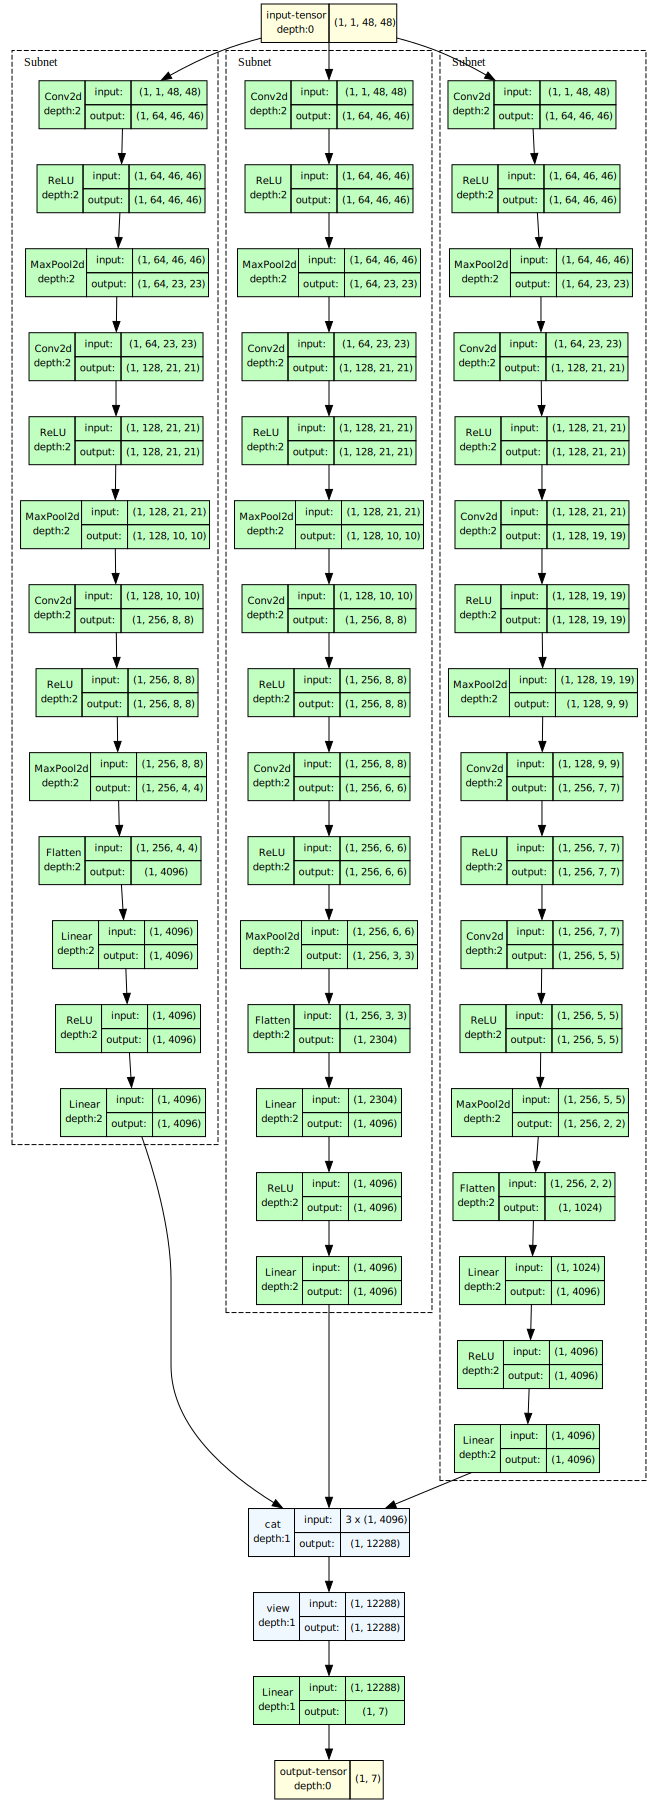

In [15]:
print(f"Number of trainable parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad)}")

from torchview import draw_graph
model_graph = draw_graph(net, input_size=(1,1,48,48), graph_dir ='TB' , roll=True, expand_nested=True, graph_name='arch',save_graph=True,filename='arch')
model_graph.visual_graph

In [84]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainingloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Training Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss / (batch_idx + 1), 100.*correct/total, correct, total))

In [85]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(validationloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Validation Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss / (batch_idx + 1), 100.*correct/total, correct, total))
        

In [86]:
print('==> Starting training')
from torchsummary import summary

for epoch in range(0, 100):
    train(epoch)
    test()

torch.save(net, 'CNN_3subnets.pth')

print('Done')

==> Starting training

Epoch: 0
Training Loss: 1.819 | Acc: 24.922% (7155/28709)
Validation Loss: 1.807 | Acc: 24.714% (1774/7178)

Epoch: 1
Training Loss: 1.795 | Acc: 25.337% (7274/28709)
Validation Loss: 1.773 | Acc: 25.815% (1853/7178)

Epoch: 2
Training Loss: 1.737 | Acc: 28.942% (8309/28709)
Validation Loss: 1.686 | Acc: 33.004% (2369/7178)

Epoch: 3
Training Loss: 1.642 | Acc: 35.923% (10313/28709)
Validation Loss: 1.585 | Acc: 39.259% (2818/7178)

Epoch: 4
Training Loss: 1.561 | Acc: 39.657% (11385/28709)
Validation Loss: 1.521 | Acc: 41.683% (2992/7178)

Epoch: 5
Training Loss: 1.504 | Acc: 41.858% (12017/28709)
Validation Loss: 1.476 | Acc: 43.327% (3110/7178)

Epoch: 6
Training Loss: 1.454 | Acc: 44.063% (12650/28709)
Validation Loss: 1.489 | Acc: 42.937% (3082/7178)

Epoch: 7
Training Loss: 1.408 | Acc: 46.013% (13210/28709)
Validation Loss: 1.389 | Acc: 47.005% (3374/7178)

Epoch: 8
Training Loss: 1.354 | Acc: 48.267% (13857/28709)
Validation Loss: 1.348 | Acc: 48.649% (34

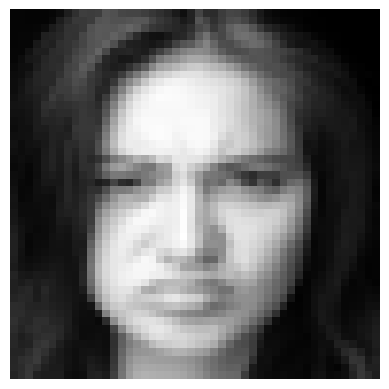

4


In [8]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt

net = torch.load('CNN_3subnets.pth')
net.eval()
net.to(device) 

image_path = 'image1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image_pil = Image.fromarray(image)

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])
input_tensor = transform(image_pil)
input_tensor = input_tensor.unsqueeze(0)

input_tensor = input_tensor.to(device)

input_np = input_tensor.squeeze().cpu().numpy()

plt.imshow(input_np, cmap='gray') 
plt.axis('off')
plt.show()

with torch.no_grad():
    outputs = net(input_tensor)

_, predicted = outputs.max(1)

print(predicted.item())